In [7]:
# %load_ext rpy2.ipython
%matplotlib inline

import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')


## Data Creation

In [144]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Parameters for MySQL connection
from config import mysql_user
from config import mysql_password
from config import mysql_host
from config import mysql_port
from config import mysql_db

# Connect to MySQL database
engine = create_engine(f'mysql+mysqldb://{mysql_user}:{mysql_password}@{mysql_host}:{mysql_port}/{mysql_db}')

# Parameters for ATM data generation
num_atms = 10  # Number of ATMs
start_date = datetime(2023, 1, 1, 0, 0)  # Start date
end_date = datetime(2023, 12, 31, 23, 59)  # End date
initial_balance = 9000000  # Initial balance after refill
withdrawal_std = 10000  # Standard deviation for withdrawals

# Generate hourly timestamps
time_range = pd.date_range(start=start_date, end=end_date, freq='h')

def create_data():
    # Create an empty DataFrame
    data = pd.DataFrame()

    # Initialize balances for all ATMs
    balances = {atm_id: initial_balance for atm_id in range(1, num_atms + 1)}

    # Populate the DataFrame with ATM balances
    for current_time in time_range:
        atm_balance = []
        
        for atm_id in range(1, num_atms + 1):
            balance = balances[atm_id]
            
            if current_time.hour == 7 and current_time.day == 1:
                balance = initial_balance  # Refill every 1st day at 7 am
            else:
                # Simulate seasonal withdrawals with hourly variation
                base_withdrawal = 1000

                # Apply a multiplier based on the hour of the day to simulate rush hours
                if 15 <= current_time.hour <= 18:  # Between 3 pm and 6 pm
                    hour_multiplier = 4.0  # Quadruple the withdrawal
                    dynamic_std = withdrawal_std * 1.5  # Increase randomness
                elif 7 <= current_time.hour <= 9:  # Morning rush hours
                    hour_multiplier = 2.0  # Double the withdrawal during morning rush hours
                    dynamic_std = withdrawal_std * 1.5  # Increase randomness during rush hours
                elif 0 <= current_time.hour < 6:  # Early morning hours
                    hour_multiplier = 0.5  # Half the withdrawal during early morning
                    dynamic_std = withdrawal_std * 2.0  # More randomness in low activity hours
                else:
                    hour_multiplier = 1.0  # Regular hours
                    dynamic_std = withdrawal_std  # Regular randomness

                # Apply weekend multiplier
                if current_time.weekday() in [5, 6]:  # Saturday or Sunday
                    weekend_multiplier = 2.0  # Double withdrawals on weekends
                else:
                    weekend_multiplier = 1.0

                # Apply monthly day multipliers
                if current_time.day == 1:
                    day_multiplier = 10.0  # 10 times withdrawal on the 1st day of the month
                elif current_time.day == 2:
                    day_multiplier = 5.0  # 5 times withdrawal on the 2nd day of the month
                elif current_time.day == 3:
                    day_multiplier = 3.0  # 3 times withdrawal on the 3rd day of the month
                else:
                    day_multiplier = 1.0

                # Simulate withdrawals with increased randomness and multipliers
                withdrawal = abs(np.random.normal(base_withdrawal * hour_multiplier * day_multiplier * weekend_multiplier, dynamic_std))
                balance = max(0, balance - withdrawal)
            
            # Update the balance for this ATM
            balances[atm_id] = balance

            # Add the current ATM data to the list
            atm_balance.append([atm_id, int(balance), current_time])

        # Convert the list to a DataFrame and concatenate it with the main data DataFrame
        atm_df = pd.DataFrame(atm_balance, columns=['ATM_ID', 'balance', 'time'])
        data = pd.concat([data, atm_df])
    
    days_in_month = data['time'].iloc[0].days_in_month
    data.iloc[0:10*7, 1] = data.iloc[0+240*days_in_month:10*7+240*days_in_month, 1].values

    # Reset index
    data.reset_index(drop=True, inplace=True)

    # Make the DataFrame MySQL-friendly
    data['ATM_ID'] = data['ATM_ID'].astype(int)
    data['balance'] = data['balance'].astype(int)
    data['time'] = pd.to_datetime(data['time'])

    # Save data to MySQL database
    data.to_sql('atm_balance', con=engine, if_exists='replace', index=False)

# Create and save data to MySQL
# create_data()



# Read data from MySQL database
data = pd.read_sql('atm_balance', con=engine)
print('\ndata length:', len(data))
print('\n', data.head(), '\n', data.tail())



data length: 87600

    ATM_ID  balance       time
0       1        0 2023-01-01
1       2     6353 2023-01-01
2       3   243499 2023-01-01
3       4   379513 2023-01-01
4       5   273652 2023-01-01 
        ATM_ID  balance                time
87595       6   318561 2023-12-31 23:00:00
87596       7   509346 2023-12-31 23:00:00
87597       8   179160 2023-12-31 23:00:00
87598       9   264212 2023-12-31 23:00:00
87599      10   111239 2023-12-31 23:00:00


## Pull Data

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import mysql.connector

# Parameters for MySQL connection
from config import mysql_user
from config import mysql_password
from config import mysql_host
from config import mysql_port
from config import mysql_db

# Connect to the MySQL database
cnx = mysql.connector.connect(user=mysql_user, password=mysql_password, host=mysql_host, port=mysql_port, database=mysql_db)

# Query to fetch the data from the "atm_balance" table
query = "SELECT * FROM atm_balance"

# Read the data into a pandas dataframe
df = pd.read_sql(query, cnx)

# Close the database connection
cnx.close()

In [9]:
df.head()

ATM_ID  balance       time
0       1        0 2023-01-01
1       2     6353 2023-01-01
2       3   243499 2023-01-01
3       4   379513 2023-01-01
4       5   273652 2023-01-01

In [10]:
df.tail()

ATM_ID  balance                time
87595       6   318561 2023-12-31 23:00:00
87596       7   509346 2023-12-31 23:00:00
87597       8   179160 2023-12-31 23:00:00
87598       9   264212 2023-12-31 23:00:00
87599      10   111239 2023-12-31 23:00:00

In [11]:
# days_in_month = df['time'].iloc[0].days_in_month
# df.tail(-68) # refill of Feb 1st
# # df.tail(-60-240*days_in_month) # refill of Feb 1st

In [12]:
# print(df.iloc[10*7-1])
# days_in_month = df['time'].iloc[0].days_in_month
# print(df.iloc[0+240*days_in_month])
# print(df.iloc[10*7-1+240*days_in_month])
# df.iloc[0:10*7, 1] = df.iloc[0+240*days_in_month:10*7+240*days_in_month, 1].values
# print()
# print(df.iloc[10*7-1])
# days_in_month = df['time'].iloc[0].days_in_month
# print(df.iloc[0+240*days_in_month])
# print(df.iloc[10*7-1+240*days_in_month])


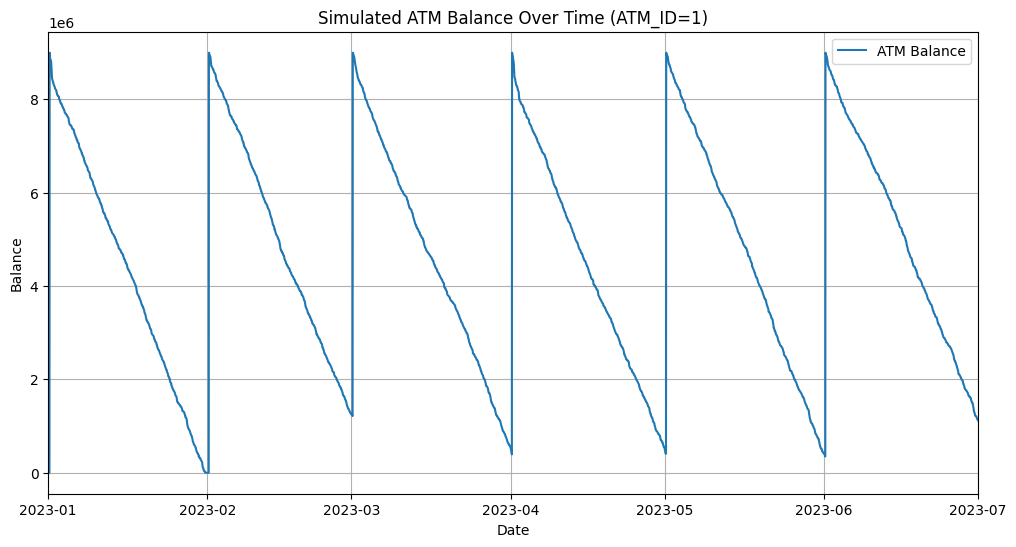

In [13]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df[df['ATM_ID'] == 1]['time'], df[df['ATM_ID'] == 1]['balance'], label='ATM Balance')
plt.title("Simulated ATM Balance Over Time (ATM_ID=1)")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.grid(True)
plt.legend()

# Set the x-axis limits
start_date = pd.to_datetime('2023-01-01')
end_date = start_date + pd.DateOffset(month=7)
plt.xlim(start_date, end_date)

# Set the y-axis limits to zoom in
# plt.ylim(6000000, 9000000)

plt.show()

In [14]:
# Get unique months from the 'time' column
unique_months = df['time'].dt.to_period('M').unique()

# Iterate over unique months and print the first day name
for month in unique_months:
    first_day = pd.to_datetime(str(month))  # Convert month to datetime
    first_day_name = first_day.strftime('%A')  # Get the day name
    print(f"First day of {month}: {first_day_name}")

First day of 2023-01: Sunday
First day of 2023-02: Wednesday
First day of 2023-03: Wednesday
First day of 2023-04: Saturday
First day of 2023-05: Monday
First day of 2023-06: Thursday
First day of 2023-07: Saturday
First day of 2023-08: Tuesday
First day of 2023-09: Friday
First day of 2023-10: Sunday
First day of 2023-11: Wednesday
First day of 2023-12: Friday


## Prophet

In [29]:
from sklearn.model_selection import train_test_split
from prophet import Prophet
import matplotlib.pyplot as plt
# m = Prophet(weekly_seasonality=False, daily_seasonality=False, n_changepoints=2)
# m = Prophet()
# m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# m.add_seasonality(name='rush_hours', period=1, fourier_order=3, condition_name='hourly_seasonality', condition_func=lambda x: (x >= 17) & (x <= 19))

# Load and preprocess the data
df_ATM_1 = df[df['ATM_ID'] == 1].copy()
df_ATM_1.drop('ATM_ID', axis=1, inplace=True)
df_ATM_1.rename(columns={'balance': 'y', 'time': 'ds'}, inplace=True)
print('\ndf_ATM_1 length:', len(df_ATM_1))
print('\n', df_ATM_1.head(), '\n', df_ATM_1.tail())


# Split the data into 80% training and 20% testing
train_df, test_df = train_test_split(df_ATM_1, test_size=0.2, shuffle=False)


# Create a regressor for the first day of each month
# train_df['first_day_of_month'] = train_df['ds'].apply(lambda x: 1 if x.day == 1 else 0)


# Define and train the model
m = Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='additive', seasonality_prior_scale=0.007)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# m.add_country_holidays(country_name='EG')
# Add the regressor to the model
# m.add_regressor('first_day_of_month')
m.fit(train_df)



df_ATM_1 length: 8760

     y                  ds
0   0 2023-01-01 00:00:00
10  0 2023-01-01 01:00:00
20  0 2023-01-01 02:00:00
30  0 2023-01-01 03:00:00
40  0 2023-01-01 04:00:00 
             y                  ds
87550  524185 2023-12-31 19:00:00
87560  521316 2023-12-31 20:00:00
87570  514820 2023-12-31 21:00:00
87580  513193 2023-12-31 22:00:00
87590  507074 2023-12-31 23:00:00


13:37:26 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# m.train_holiday_names

In [31]:
# Make future dataframe for prediction (extend it to cover the test set as well)
future = m.make_future_dataframe(periods=len(test_df), freq='h')

# Include the regressor in the future dataframe
# future['first_day_of_month'] = future['ds'].apply(lambda x: 1 if x.day == 1 else 0)

print('\nFuture dataframe length:', len(future))
print('\n', future.head(), '\n', future.tail())





Future dataframe length: 8760

                    ds
0 2023-01-01 00:00:00
1 2023-01-01 01:00:00
2 2023-01-01 02:00:00
3 2023-01-01 03:00:00
4 2023-01-01 04:00:00 
                       ds
8755 2023-12-31 19:00:00
8756 2023-12-31 20:00:00
8757 2023-12-31 21:00:00
8758 2023-12-31 22:00:00
8759 2023-12-31 23:00:00


In [32]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds          yhat    yhat_lower    yhat_upper
8755 2023-12-31 19:00:00  4.257938e+06  2.252779e+06  6.278794e+06
8756 2023-12-31 20:00:00  4.345555e+06  2.247982e+06  6.412240e+06
8757 2023-12-31 21:00:00  4.420503e+06  2.283221e+06  6.396626e+06
8758 2023-12-31 22:00:00  4.488166e+06  2.331705e+06  6.637468e+06
8759 2023-12-31 23:00:00  4.560861e+06  2.494667e+06  6.552742e+06

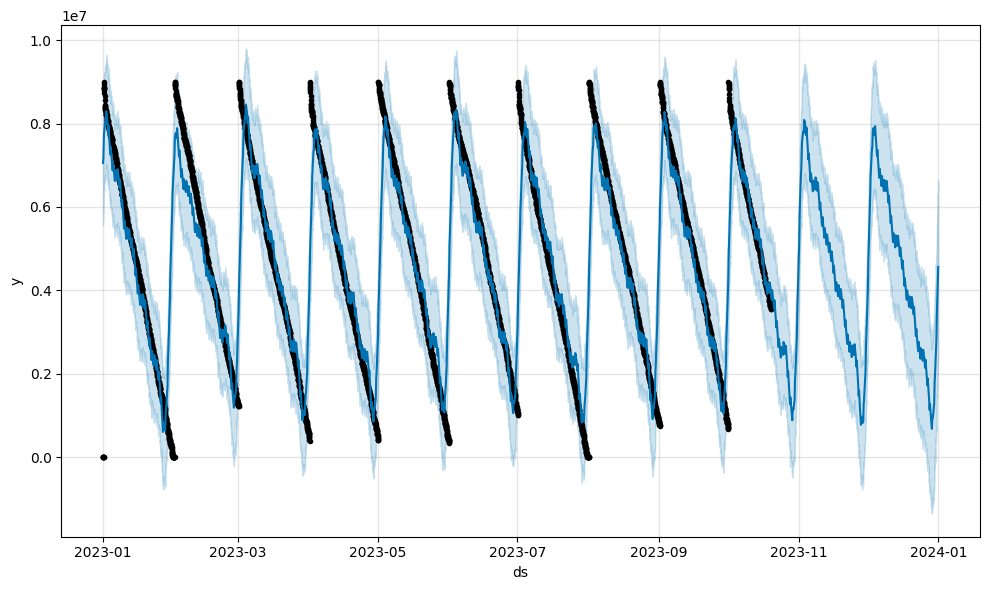

In [33]:
fig1 = m.plot(forecast)


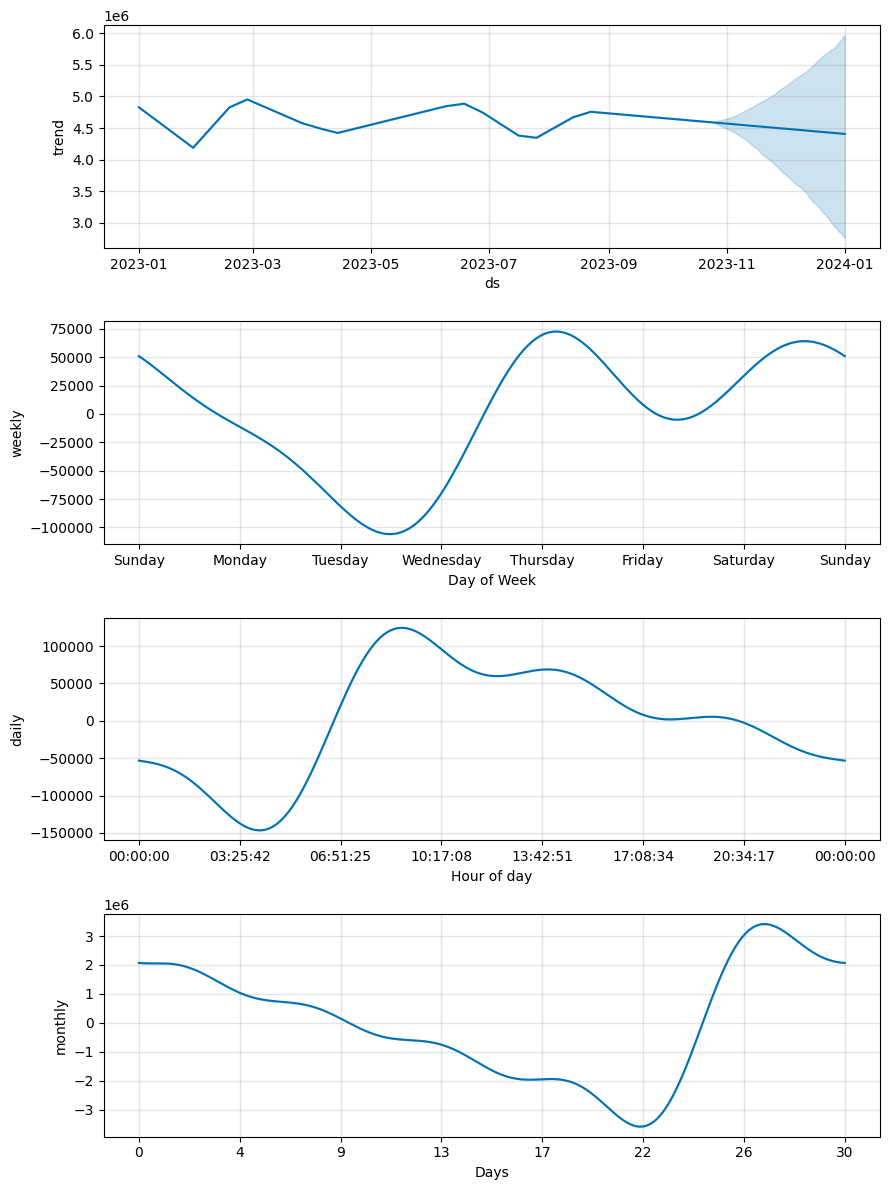

In [34]:
fig2 = m.plot_components(forecast)


                     error_percentage   error_value
time                                               
2023-01-01 00:00:00               NaN           NaN
2023-01-01 01:00:00               NaN           NaN
2023-01-01 02:00:00               NaN           NaN
2023-01-01 03:00:00               NaN           NaN
2023-01-01 04:00:00               NaN           NaN
...                               ...           ...
2023-12-31 19:00:00        712.296854  3.733753e+06
2023-12-31 20:00:00        733.574123  3.824239e+06
2023-12-31 21:00:00        758.650120  3.905683e+06
2023-12-31 22:00:00        774.557095  3.974973e+06
2023-12-31 23:00:00        799.446914  4.053787e+06

[8760 rows x 2 columns]


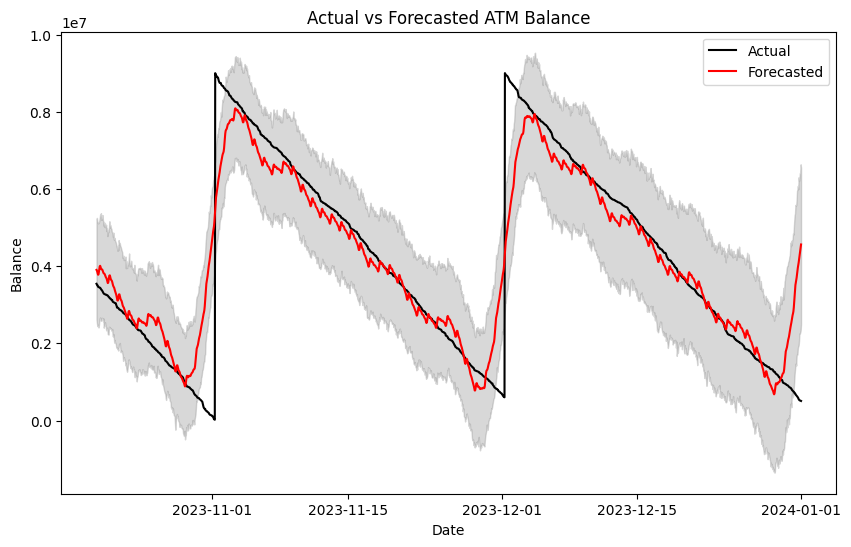

In [35]:
df_ts = pd.DataFrame(test_df)
df_ts['time'] = pd.to_datetime(df_ts['ds'])
df_ts.set_index('time', inplace=True)

df_forecast = pd.DataFrame(forecast)
df_forecast['time'] = pd.to_datetime(df_forecast['ds'])
df_forecast.set_index('time', inplace=True)

# error percentage and value
error_percentage = ((df_forecast['yhat'] - df_ts['y']) / df_ts['y']) * 100
error_value = df_forecast['yhat'] - df_ts['y']

# combine
error_df = pd.DataFrame({'error_percentage': error_percentage, 'error_value': error_value})

print(error_df)


# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', color='black')
plt.plot(forecast['ds'].tail(len(test_df)), forecast['yhat'].tail(len(test_df)), label='Forecasted', color='red')
plt.fill_between(forecast['ds'].tail(len(test_df)), 
                 forecast['yhat_lower'].tail(len(test_df)), 
                 forecast['yhat_upper'].tail(len(test_df)), 
                 color='gray', alpha=0.3)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Actual vs Forecasted ATM Balance')
plt.show()


In [36]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


In [37]:
plot_components_plotly(m, forecast)


In [38]:
from sklearn.linear_model import LinearRegression

f = forecast[['ds', 'yhat']]
f['yhat'] = f['yhat'].astype(int)
print(f)



                      ds     yhat
0    2023-01-01 00:00:00  7056480
1    2023-01-01 01:00:00  7108271
2    2023-01-01 02:00:00  7142820
3    2023-01-01 03:00:00  7164045
4    2023-01-01 04:00:00  7197350
...                  ...      ...
8755 2023-12-31 19:00:00  4257938
8756 2023-12-31 20:00:00  4345555
8757 2023-12-31 21:00:00  4420502
8758 2023-12-31 22:00:00  4488165
8759 2023-12-31 23:00:00  4560861

[8760 rows x 2 columns]


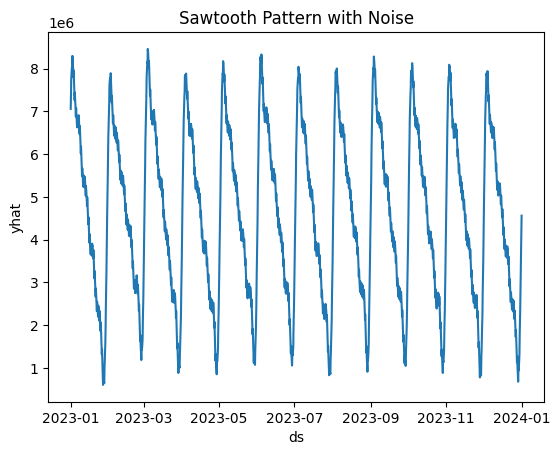

Ramp 1: y = 0 at ds = 2023-02-01 11:53
Ramp 2: y = 0 at ds = 2023-03-08 07:17
Ramp 3: y = 0 at ds = 2023-04-04 22:29
Ramp 4: y = 0 at ds = 2023-05-05 18:44
Ramp 5: y = 0 at ds = 2023-06-06 07:01
Ramp 6: y = 0 at ds = 2023-07-06 08:09
Ramp 7: y = 0 at ds = 2023-08-04 07:05
Ramp 8: y = 0 at ds = 2023-09-05 17:23
Ramp 9: y = 0 at ds = 2023-10-05 14:02
Ramp 10: y = 0 at ds = 2023-11-04 19:34
Ramp 11: y = 0 at ds = 2023-12-04 20:36
Ramp 12: y = 0 at ds = 2024-01-04 01:47


In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Plot the data to visualize the sawtooth pattern with noise
plt.plot(f['ds'], f['yhat'])
plt.xlabel('ds')
plt.ylabel('yhat')
plt.title('Sawtooth Pattern with Noise')
plt.show()

# Function to convert datetime `ds` to numeric (timestamp) for regression
def convert_to_timestamp(df):
    df['ds_numeric'] = df['ds'].apply(lambda x: x.timestamp())  # Convert to Unix timestamp
    return df

# Convert datetime `ds` to numeric
f = convert_to_timestamp(f)

# Function to extract ramps based on significant `yhat` differences
def extract_ramps(df, threshold=5000000):
    ramps = []
    ramp_start_idx = 0

    # Loop through the rows and detect significant drops in `yhat`
    for i in range(1, len(df)):
        if df['yhat'].iloc[i] - df['yhat'].iloc[i - 150] > threshold:
            # Only consider it a new ramp if the jump is greater than the threshold
            ramps.append(df.iloc[ramp_start_idx:i].copy())
            ramp_start_idx = i

    # Append the last ramp (if any data remains and if not empty)
    if ramp_start_idx < len(df) and len(df) > ramp_start_idx:
        ramps.append(df.iloc[ramp_start_idx:].copy())
    
    return ramps

# Extract ramps using the difference in `yhat`
ramps = extract_ramps(f, threshold=500000)

# Placeholder for storing x-values where y = 0 for each ramp
x_intercepts = []

# Iterate over each ramp and perform linear regression
for ramp in ramps:
    # Extract the numeric ds (ds_numeric) and yhat values
    X = ramp['ds_numeric'].values.reshape(-1, 1)
    y = ramp['yhat'].values

    # Apply linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Get the slope (m) and intercept (c)
    m = model.coef_[0]
    c = model.intercept_
    
    # Calculate x (timestamp) where y = 0 (x = -c/m)
    if m != 0:  # Ensure there's no division by zero
        x_zero_timestamp = -c / m
        # Convert back to datetime
        x_intercepts.append(pd.to_datetime(x_zero_timestamp, unit='s'))

# Output the results
for i, x_zero in enumerate(x_intercepts):
    formatted_date = x_zero.strftime('%Y-%m-%d %H:%M')  # Format to include only date and hour
    print(f"Ramp {i+1}: y = 0 at ds = {formatted_date}")


In [40]:
print(f)
min_yhat = f['yhat'].min()
max_yhat = f['yhat'].max()
print("Minimum yhat value:", min_yhat)
print("Maximum yhat value:", max_yhat)

                      ds     yhat    ds_numeric
0    2023-01-01 00:00:00  7056480  1.672531e+09
1    2023-01-01 01:00:00  7108271  1.672535e+09
2    2023-01-01 02:00:00  7142820  1.672538e+09
3    2023-01-01 03:00:00  7164045  1.672542e+09
4    2023-01-01 04:00:00  7197350  1.672546e+09
...                  ...      ...           ...
8755 2023-12-31 19:00:00  4257938  1.704049e+09
8756 2023-12-31 20:00:00  4345555  1.704053e+09
8757 2023-12-31 21:00:00  4420502  1.704056e+09
8758 2023-12-31 22:00:00  4488165  1.704060e+09
8759 2023-12-31 23:00:00  4560861  1.704064e+09

[8760 rows x 3 columns]
Minimum yhat value: 602988
Maximum yhat value: 8458152


In [41]:
f.tail(-24*31-30)

ds     yhat    ds_numeric
774  2023-02-02 06:00:00  7738570  1.675318e+09
775  2023-02-02 07:00:00  7820677  1.675321e+09
776  2023-02-02 08:00:00  7880175  1.675325e+09
777  2023-02-02 09:00:00  7890134  1.675328e+09
778  2023-02-02 10:00:00  7857334  1.675332e+09
...                  ...      ...           ...
8755 2023-12-31 19:00:00  4257938  1.704049e+09
8756 2023-12-31 20:00:00  4345555  1.704053e+09
8757 2023-12-31 21:00:00  4420502  1.704056e+09
8758 2023-12-31 22:00:00  4488165  1.704060e+09
8759 2023-12-31 23:00:00  4560861  1.704064e+09

[7986 rows x 3 columns]

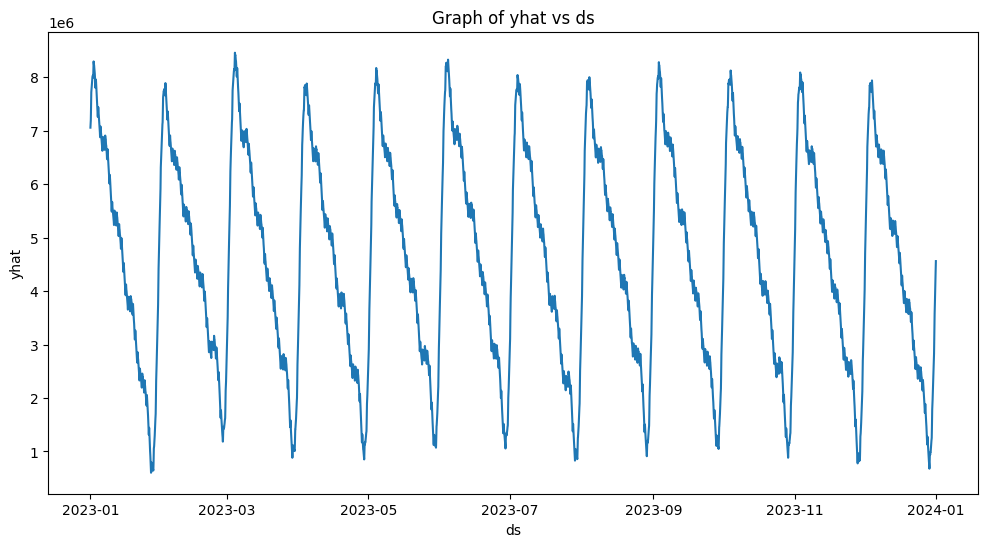

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(f['ds'], f['yhat'])
plt.xlabel('ds')
plt.ylabel('yhat')
plt.title('Graph of yhat vs ds')
plt.show()